In [2]:
import pandas as pd
import os
from datetime import datetime, timedelta
import pickle
import numpy as np
import time
from multiprocessing import Pool

In [266]:
# Functions 
def vector_angle_diff(a1, a2):
    return np.abs(np.where(abs(a1-a2)>180, abs(a1-a2)-360, abs(a1-a2)))

def vector_distance(lat1, lon1, lat2, lon2):
    return ((lat1-lat2)**2 + (lon1-lon2)**2)**0.5

def algorithm(_df, max_wait_mins=7, max_occupancy=6, angle_thresh=20, dist_thresh=0.15):
    """algorithm for efficiently identifying routes to combine"""
    agg_rides = []
    if len(_df.shape) == 1:
        return _df
    df = _df.copy()
    
    agg_ride_dict_ = {f'ride_id_{i}':float("NaN") for i in range(max_occupancy)}
    while df.shape[0]>1:
        agg_ride_dict = agg_ride_dict_.copy()
        i = df.index[0]
        agg_ride_dict['ride_id_0'] = i
        row = df.loc[i,:]
        initial_passengers = row['passenger_count']
        df.drop(index=i, inplace=True)

        # Find rows going in similar directions
        angle_diffs = vector_angle_diff(df['direction'], row['direction'])
        matches = df[angle_diffs<angle_thresh]

        # Find rows with aligned start points
        fractional_distance_start = vector_distance(
            lat1 = matches['pickup_latitude'],
            lon1 = matches['pickup_longitude'],
            lat2 = row['pickup_latitude'],
            lon2 = row['pickup_longitude'],
        ) / np.minimum(matches['euclidean_length'], row['euclidean_length'])
        time_diff_start = matches['tpep_pickup_datetime'] - row['tpep_pickup_datetime']
        aligned_start = (
                time_diff_start.dt.total_seconds().between(0,max_wait_mins*60)
                & (fractional_distance_start<dist_thresh)
        )

        # Find rows with aligned end points
        fractional_distance_end = vector_distance(
            lat1 = matches['dropoff_latitude'],
            lon1 = matches['dropoff_longitude'],
            lat2 = row['dropoff_latitude'],
            lon2 = row['dropoff_longitude'],
        ) / np.minimum(matches['euclidean_length'], row['euclidean_length'])
        time_diff_end = matches['tpep_dropoff_datetime'] - row['tpep_dropoff_datetime']
        aligned_end = (
                time_diff_end.dt.total_seconds().between(0,max_wait_mins*60)
                & (fractional_distance_end<dist_thresh)
        )

        matches.loc[:,'alignment'] = aligned_start.astype(int) + aligned_end.astype(int)
        matches = matches[matches['alignment']>0]
        matches.sort_values(by=['alignment','euclidean_length'],ascending=False, inplace=True)
        cumulative_passengers = matches['passenger_count'].cumsum()
        matches = matches[cumulative_passengers<=(max_occupancy-initial_passengers)]

        for i, idx in enumerate(matches.index):
            agg_ride_dict[f'ride_id_{i+1}'] = idx
        df.drop(index=matches.index.values, inplace=True)
        agg_rides.append(agg_ride_dict)
    return pd.DataFrame(agg_rides)def algorithm(_df, max_wait_mins=7, max_occupancy=6, angle_thresh=20, dist_thresh=0.15):
    agg_rides = []
    if len(_df.shape) == 1:
        return _df
    df = _df.copy()
    
    agg_ride_dict_ = {f'ride_id_{i}':float("NaN") for i in range(max_occupancy)}
    while df.shape[0]>1:
        agg_ride_dict = agg_ride_dict_.copy()
        i = df.index[0]
        agg_ride_dict['ride_id_0'] = i
        row = df.loc[i,:]
        initial_passengers = row['passenger_count']
        df.drop(index=i, inplace=True)

        # Find rows going in similar directions
        angle_diffs = vector_angle_diff(df['direction'], row['direction'])
        matches = df[angle_diffs<angle_thresh]

        # Find rows with aligned start points
        fractional_distance_start = vector_distance(
            lat1 = matches['pickup_latitude'],
            lon1 = matches['pickup_longitude'],
            lat2 = row['pickup_latitude'],
            lon2 = row['pickup_longitude'],
        ) / np.minimum(matches['euclidean_length'], row['euclidean_length'])
        time_diff_start = matches['tpep_pickup_datetime'] - row['tpep_pickup_datetime']
        aligned_start = (
                time_diff_start.dt.total_seconds().between(0,max_wait_mins*60)
                & (fractional_distance_start<dist_thresh)
        )

        # Find rows with aligned end points
        fractional_distance_end = vector_distance(
            lat1 = matches['dropoff_latitude'],
            lon1 = matches['dropoff_longitude'],
            lat2 = row['dropoff_latitude'],
            lon2 = row['dropoff_longitude'],
        ) / np.minimum(matches['euclidean_length'], row['euclidean_length'])
        time_diff_end = matches['tpep_dropoff_datetime'] - row['tpep_dropoff_datetime']
        aligned_end = (
                time_diff_end.dt.total_seconds().between(0,max_wait_mins*60)
                & (fractional_distance_end<dist_thresh)
        )

        matches.loc[:,'alignment'] = aligned_start.astype(int) + aligned_end.astype(int)
        matches = matches[matches['alignment']>0]
        matches.sort_values(by=['alignment','euclidean_length'],ascending=False, inplace=True)
        cumulative_passengers = matches['passenger_count'].cumsum()
        matches = matches[cumulative_passengers<=(max_occupancy-initial_passengers)]

        for i, idx in enumerate(matches.index):
            agg_ride_dict[f'ride_id_{i+1}'] = idx
        df.drop(index=matches.index.values, inplace=True)
        agg_rides.append(agg_ride_dict)
    return pd.DataFrame(agg_rides)

In [3]:
df = pd.read_csv(
    os.path.join('data','yellow_tripdata_2016-06.csv'), 
    parse_dates=['tpep_dropoff_datetime','tpep_pickup_datetime']
)

In [5]:
df['day-of-week']

0           Thu
1           Thu
2           Thu
3           Thu
4           Thu
           ... 
11135465    Tue
11135466    Tue
11135467    Tue
11135468    Tue
11135469    Tue
Name: day-of-week, Length: 11135470, dtype: object

In [6]:
df['time-of-day'] = df['tpep_pickup_datetime'].dt.strftime("%H")
df['day-of-week'] = df['tpep_pickup_datetime'].dt.strftime("%a")

In [9]:
df['time-of-day']

0           21
1           21
2           21
3           21
4           21
            ..
11135465    22
11135466    22
11135467    22
11135468    22
11135469    22
Name: time-of-day, Length: 11135470, dtype: object

In [10]:
df_sat_afternoon = df[(df['day-of-week']=='Sat') | (df['time-of-day'].astype(int).between(11, 4))]

In [12]:
with open('data/sat_afternoon_df.pkl','wb') as f:
     pickle.dump(df_sat_afternoon, f)

In [15]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : 945c9ed766a61c7d2c0a7cbb251b6edebf9cb7d5
python           : 3.7.4.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19041
machine          : AMD64
processor        : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 1.3.4
numpy            : 1.20.3
pytz             : 2021.1
dateutil         : 2.8.2
pip              : 21.0.1
setuptools       : 58.0.4
Cython           : 0.29.13
pytest           : 5.2.1
hypothesis       : None
sphinx           : 2.2.0
blosc            : None
feather          : None
xlsxwriter       : 1.2.1
lxml.etree       : 4.4.1
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.8.6 (dt dec pq3 ext lo64)
jinja2           : 2.10.3
IPython          : 7.20.0
pandas_datareader: None
bs4              : 4.8.0
bottleneck      

In [267]:

# filter to first week of June
first_week_start = datetime(year=2016, month=6, day=6, hour=0, minute=0, second=0)
first_week_end = datetime(year=2016, month=6, day=13, hour=0, minute=0, second=0)
print(f"Num rows in df reduced from {df.shape[0]} ", end="")
df = df[(df['tpep_pickup_datetime']>=first_week_start) & (df['tpep_dropoff_datetime']<first_week_end)]
print(f"to {df.shape[0]} ")

df['duration_minutes'] = (df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']).apply(lambda x: x.total_seconds()/60)
# = ((df['pickup_longitude']-df['dropoff_longitude'])**2 + (df['pickup_latitude']-df['dropoff_latitude'])**2)**0.5
df = df.sort_values(['tpep_pickup_datetime'])
df['passenger_count'].fillna(2, inplace=True)
df.sample(3)

df['direction'] = np.rad2deg(
    np.arctan2(
        df['dropoff_latitude']-df['pickup_latitude'], 
        df['dropoff_longitude']-df['pickup_longitude']
    )
)

df['euclidean_length'] = vector_distance(
    lat1 = df['pickup_latitude'], 
    lon1 = df['pickup_longitude'],
    lat2 = df['dropoff_latitude'], 
    lon2 = df['dropoff_longitude'],
)

df['day-of-week'] = df['tpep_pickup_datetime'].dt.strftime("%a")

Num rows in df reduced from 11135470 to 2624066 


### Apply algorithm in distributed manner

In [ ]:
results = []
with Pool(4) as p:
    for i, result in enumerate(p.imap_unordered(algorithm, np.array_split(df, 32)), 1):
        sys.stderr.write('\rdone {0:%}'.format(i/32))
        results.append(result)

In [270]:
results_df = pd.concat(results)

In [272]:
df.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration_minutes,direction,euclidean_length
2128992,1,2016-06-06,2016-06-06 00:16:57,1,6.60,-73.946548,40.785099,1,N,-73.923866,...,20.0,0.5,0.5,0.00,0.00,0.3,21.30,16.950000,44.903478,0.032024
2765158,2,2016-06-06,2016-06-06 18:07:49,1,2.02,-73.978745,40.750641,1,N,-73.997108,...,10.0,1.3,0.5,1.25,0.00,0.3,13.35,1087.816667,-125.620677,0.031531
2765157,2,2016-06-06,2016-06-06 00:00:00,1,4.27,-73.952385,40.741501,2,N,-74.004097,...,52.0,0.0,0.5,0.00,5.54,0.3,58.34,0.000000,-158.291198,0.055660


In [273]:
results_df.head(3)

,ride_id_0,ride_id_1,ride_id_2,ride_id_3,ride_id_4,ride_id_5
0,3021109,3022704.0,3020821.0,3024802.0,3022388.0,NaN
1,3021110,3020931.0,3021851.0,3021617.0,NaN,NaN
2,3021111,3021865.0,3021566.0,3021070.0,3022173.0,NaN


# Geography

In [269]:
import fiona
import shapely
import shapely.geometry

# Load shape files
shape_dict = {}
with fiona.open("data/Borough Boundaries/geo_export_86f96b0c-2916-4b73-b089-ba632d5abdd7.shp") as fiona_collection:
    for record in fiona_collection:  
        name = record['properties']['boro_name']
        shape = shapely.geometry.asShape(record['geometry'])
        shape_dict[name] = {'shape':shape}

# get bounding box of each boro
for boro in shape_dict:
    x0, y0, x1, y1 = shape_dict[boro]['shape'].bounds
    shape_dict[boro]['x0'] = x0
    shape_dict[boro]['y0'] = y0
    shape_dict[boro]['x1'] = x1
    shape_dict[boro]['y1'] = y1
    shape_dict[boro]['bounds'] = shapely.geometry.box(minx, miny, maxx, maxy)
    tol = min(x1-x0, y1-y0)/2000
    shape_dict[boro]['shape_simp'] = shape_dict[boro]['shape'].simplify(tol)

boro_names = list(shape_dict.keys())

def get_potential_boros(df, shape_dict):
    potential_boros = pd.DataFrame(index=df.index)
    for boro in shape_dict:
        in_boro = df['pickup_longitude'].between(shape_dict[boro]['x0'], shape_dict[boro]['x1'])
        in_boro = in_boro & df['pickup_latitude'].between(shape_dict[boro]['y0'], shape_dict[boro]['y1'])
        potential_boros[boro] = in_boro
    return potential_boros

def get_clear_boros(df, shape_dict):
    # label boros that are unambiguous based on bounding box
    potential_boros = get_potential_boros(df, shape_dict)
    clear_boros = potential_boros[potential_boros.sum(axis=1)==1]
    clear_boros = clear_boros.stack().reset_index()
    clear_boros = clear_boros[clear_boros[0]==True]
    return clear_boros

In [276]:
def get_optimal_route(coords, plot=True):
    """Given a dataframe of trips, find a single,. efficient route that incorporates all trips"""
    start_points = coords[['pickup_longitude', 'pickup_latitude']].values
    end_points = coords[['dropoff_longitude', 'dropoff_latitude']].values
    avg_start = start_points.mean(axis=0)
    avg_end = end_points.mean(axis=0)

    start_points -= avg_start
    end_points -= avg_start
    avg_end -= avg_start

    start_projections = np.dot(start_points, avg_end)
    end_projections = np.dot(end_points, avg_end)
    
    pu_names = ['00','10','20','30','40','50']
    do_names = ['01','11','21','31','41','51']
    
    locations = pu_names[:coords.shape[0]]+do_names[:coords.shape[0]]
    projections = np.concatenate([start_projections,end_projections])
    
    _, sorted_locations = zip(*sorted(zip(projections, locations)))
    sorted_locations = list(sorted_locations)
    route = []
    while len(sorted_locations)>0:
        for i in range(len(sorted_locations)):
            loc = sorted_locations[i]
            if loc[1]=='0':
                route.append(loc)
                sorted_locations.pop(i)
                break
            else:
                if loc[0]+'0' in route:
                    route.append(loc)
                    sorted_locations.pop(i)
                    break
                else:
                    continue
    
    if plot:
        for idx in coords.index:
            #print(coords.loc[idx, 'pickup_latitude'])
            plt.arrow(
                x=coords.loc[idx, 'pickup_latitude'], 
                y=coords.loc[idx, 'pickup_longitude'], 
                dx=coords.loc[idx, 'dropoff_latitude']-coords.loc[idx, 'pickup_latitude'], 
                dy=coords.loc[idx, 'dropoff_longitude']-coords.loc[idx, 'pickup_longitude']
            )
    
    
    first_trip = coords.iloc[int(route[0][0]),:]
    last_stop_location = first_trip[['pickup_latitude','pickup_longitude']].values
    total_distance = 0
    if plot:
        plt.scatter(first_trip['pickup_latitude'],first_trip['pickup_longitude'])
    for stop in route[1:]:
        trip = coords.iloc[int(stop[0]),:]
        pu_do = 'pickup' if stop[1]=='0' else 'dropoff'
        location = trip[[pu_do+"_latitude",pu_do+'_longitude']].values
        distance = ((last_stop_location-location)**2).sum()**0.5
        total_distance += distance
        if plot:
            plt.plot([last_stop_location[0],location[0]], [last_stop_location[1],location[1]], c="red")
        last_stop_location = location
    if plot:
        plt.show()
    return route, total_distance

In [277]:
def plot_rides(ride_ids):
    pu_lats = df.loc[ride_ids,'pickup_latitude']
    pu_lons = df.loc[ride_ids,'pickup_longitude']
    do_lats = df.loc[ride_ids,'dropoff_latitude']
    do_lons = df.loc[ride_ids,'dropoff_longitude']
    for pu_lat, pu_lon, do_lat, do_lon in zip(pu_lats, pu_lons, do_lats, do_lons):
        plt.arrow(pu_lon, pu_lat, dx=do_lon-pu_lon, dy=do_lat-pu_lat)#, width=.01,head_width=.02)
    plt.show()

In [299]:
merged_df = results_df.merge(df, left_on='ride_id_0', right_index=True,how='left')

In [312]:
def calculate_efficiency(results, n_samples, df):
    trips_in_route = results.notna().sum(axis=1)
    vcs = trips_in_route.value_counts()

    efficiency_dict = {}
    for count in vcs.index:
        single_trip_ids = list(results['ride_id_0'][trips_in_route==1].values)
        if count == 1:
            coords = df.loc[single_trip_ids,:]
            efficiency_dict[1] = dict(
                num_trips=vcs[count],
                person_miles = (coords['euclidean_length']*coords['passenger_count']).sum(),
                natural_car_miles = coords['euclidean_length'].sum(),
                optimal_car_miles = coords['euclidean_length'].sum(),
            )
            continue
        agg_df_count = results[trips_in_route==count]
        agg_df_count = agg_df_count.sample(min(n_samples, agg_df_count.shape[0]))

        tot_opt_car_distance = 0
        tot_natural_car_distance = 0
        tot_person_distance = 0
        for i in range(agg_df_count.shape[0]):
            ride_ids = [int(v) for v in agg_df_count.iloc[i,:] if not np.isnan(v)]
            coords = df.loc[ride_ids,:]
            route, opt_car_distance = get_optimal_route(coords, plot=False)
            natural_car_distance = coords['euclidean_length'].sum()
            person_distance = (coords['euclidean_length']*coords['passenger_count']).sum()
            tot_opt_car_distance += opt_car_distance
            tot_natural_car_distance += natural_car_distance
            tot_person_distance += person_distance
        
        scale_ratio = vcs[count]/agg_df_count.shape[0]
        efficiency_dict[count] = dict(
            num_trips=vcs[count],
            person_miles = tot_person_distance * scale_ratio,
            natural_car_miles = tot_natural_car_distance * scale_ratio,
            optimal_car_miles = tot_opt_car_distance * scale_ratio,
        )

        #perc_improved_efficiency = tot_natural_car_distance/tot_opt_car_distance
        #avg_efficiency = tot_person_distance/tot_opt_car_distance
        #print(f"{count}: {100*avg_efficiency:0.2f}% efficiency, ({100*perc_improved_efficiency-100:0.2f}% improvement)")
    return efficiency_dict

In [308]:
def overall_efficiency(efficiency_dict):
    tot_person_miles = sum([efficiency_dict[k]['person_miles'] for k in efficiency_dict])
    tot_optimal_car_miles = sum([efficiency_dict[k]['optimal_car_miles'] for k in efficiency_dict])
    tot_natural_car_miles = sum([efficiency_dict[k]['natural_car_miles'] for k in efficiency_dict])
    return tot_person_miles/tot_natural_car_miles, tot_person_miles/tot_optimal_car_miles

In [323]:
def apply_efficiency_calculation(merged):
    results = merged.loc[:,['ride_id_0','ride_id_1','ride_id_2','ride_id_3','ride_id_4','ride_id_5']]
    efficiency_dict = calculate_efficiency(results, n_samples=20, df=df)
    e0, e1 = overall_efficiency(efficiency_dict)
    return pd.Series(index=["e0","e1"],data=[e0,e1])

In [341]:
clear_boros = get_clear_boros(merged_df, shape_dict)
merged_df_boros = clear_boros.merge(merged_df, left_on='ride_id_0', right_index=True)
merged_df_boros = merged_df_boros.rename(columns={'level_1':'boro'})

In [324]:
efficiency_calc = merged_df.groupby(['time-of-day','day-of-week']).apply(apply_efficiency_calculation)

In [382]:
overall_e0, overall_e1 = apply_efficiency_calculation(merged_df_boros[merged_df_boros['boro']=='Manhattan'])

In [383]:
overall_e0, overall_e1

(1.9101721673182235, 3.092369175194658)

In [342]:
efficiency_calc_boro = merged_df_boros.groupby(['time-of-day','day-of-week','boro']).apply(apply_efficiency_calculation)

C:\Users\volpir\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [359]:
#efficiency_calc_day_boro = merged_df_boros.groupby(['day-of-week','boro']).apply(apply_efficiency_calculation)
efficiency_calc_day_boro['improvement'] = efficiency_calc_day_boro['e1']/efficiency_calc_day_boro['e0']-1

In [360]:
#efficiency_calc_hour_boro = merged_df_boros.groupby(['time-of-day','boro']).apply(apply_efficiency_calculation)
efficiency_calc_hour_boro['improvement'] = efficiency_calc_hour_boro['e1']/efficiency_calc_hour_boro['e0']-1

Text(0, 0.5, 'Increase in person-miles per vehicle-mile')

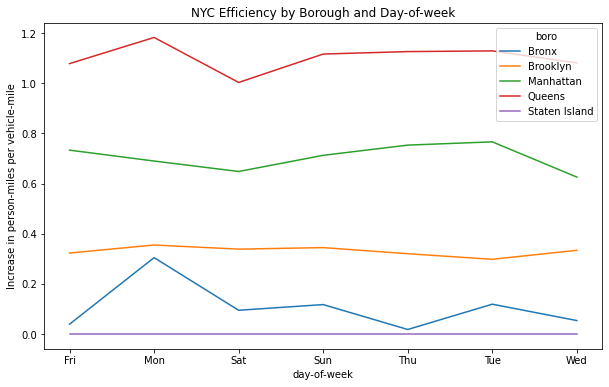

In [386]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.lineplot(
    data=efficiency_calc_day_boro,
    x='day-of-week',
    hue='boro',
    y='improvement'
)
plt.title("NYC Efficiency by Borough and Day-of-week")
plt.ylabel('Increase in person-miles per vehicle-mile')

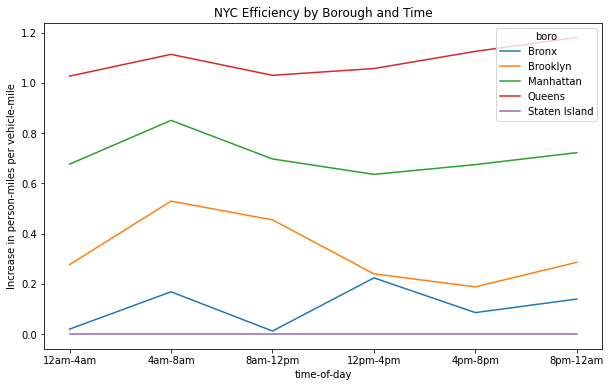

In [384]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=efficiency_calc_hour_boro,
    x='time-of-day',
    hue='boro',
    y='improvement',
)
plt.ylabel('Increase in person-miles per vehicle-mile')
plt.xticks([0,1,2,3,4,5],['12am-4am','4am-8am','8am-12pm','12pm-4pm','4pm-8pm','8pm-12am']) 
plt.title("NYC Efficiency by Borough and Time")
plt.show()

40.64477157592773
40.64717864990234
40.644493103027344
40.64351272583008
40.644649505615234
40.64456558227539


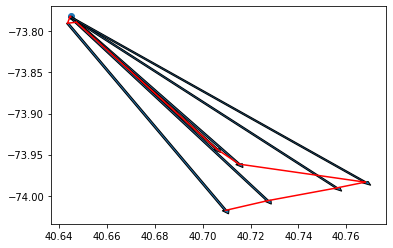

(['00', '50', '40', '20', '30', '10', '11', '01', '51', '41', '21', '31'],
 0.3227985399364087)

In [202]:
ride_ids = list(agg_df_count.iloc[0,:].astype(int).values)
get_optimal_route(df_sample.loc[ride_ids,:])